In [1]:
import sys
import os

root_pth = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_pth not in sys.path:
    sys.path.append(root_pth)

In [2]:
from alchemist import Alchemist

In [3]:
prompt = """AI-generated. synthetic. photo. photorealistic. midjourney. rendering. instagram filters."""
alchemist_model = Alchemist(model_id="Efficient-Large-Model/Sana_600M_1024px_diffusers", K=100, prompt=prompt)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

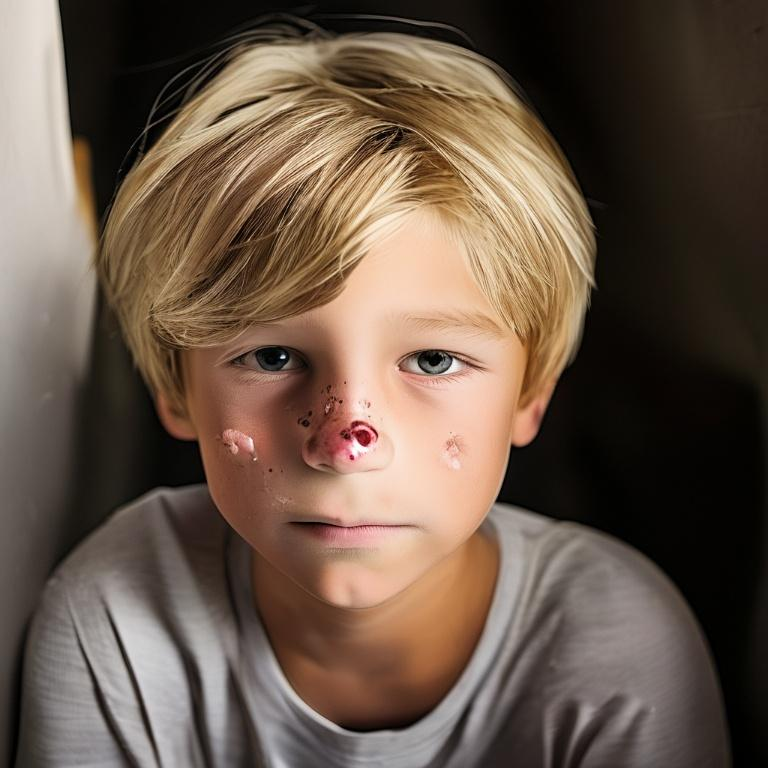

In [4]:
from PIL import Image
from glob import glob

img = Image.open(glob("/workspace/val/sana/sana_600M/*.jpg")[0])

img

In [5]:
alchemist_model.pipe(image=img, prompt=prompt, t=.25)

In [6]:
import pandas as pd
from pathlib import Path, PureWindowsPath

N_samples = 2000

def load_csv(csv_path, dir_path):
    def set_abs_pth(x):
        return (dir_path / Path(PureWindowsPath(x).as_posix())).as_posix()
    df = pd.read_csv(Path(dir_path) / csv_path)
    df["fp"] = df["fp"].apply(set_abs_pth)
    return df

df = load_csv("train.csv", "/workspace/train")

In [7]:
synth_pths = df["fp"][df["label"] == 1].sample(N_samples // 2, random_state=42)

In [8]:
real_pths = df["fp"][df["label"] == 0].sample(N_samples // 2, random_state=42)

In [9]:
pos_images_pths = [p for p in real_pths]
neg_images_pths = [p for p in synth_pths]

In [10]:
res = alchemist_model.collect_separation_scores(
    x_positive=pos_images_pths,
    x_negative=neg_images_pths
)

  0%|          | 0/1000 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

In [11]:
alchemist_model.score(img=img).item()

712.0

In [12]:
import pandas as pd

test_df = load_csv("val.csv", "/workspace/val")[["fp", "label"]].sample(5000, random_state=42).reset_index()

In [13]:
from tqdm import tqdm
from torch.utils.data import DataLoader

X = alchemist_model.dataset(test_df["fp"])
x_loader = DataLoader(
    X,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    collate_fn=X.collate_pil_images
)
K = 100 # alchemist_model.K
alchemist_model._topk_separation_scores = alchemist_model.get_topK_separation_scores(K)
for idx, x in enumerate(tqdm(x_loader)):
    test_df.loc[idx, "score"] = alchemist_model.score(img=x).item()
    collected = alchemist_model.collector.get_collected()
    for (prc_name, token_idx), _ in alchemist_model.topk_separation_scores.items():
        test_df.loc[idx, f"x_{prc_name}_{token_idx}"] = collected[prc_name].squeeze(0)[token_idx].item()

  0%|          | 0/5000 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# 1. Предположим, что test_df уже загружен и выглядит примерно так:
#    test_df = pd.read_csv('path_to_your_data.csv')
#
#    Он должен содержать два столбца:
#    - 'score'  : float (числовой скор, по которому будем классифицировать)
#    - 'label'  : 0 или 1 (истинная метка)

# 2. Разбиваем данные на признаки (X) и метки (y)
X = test_df[['score']].values  # надо передавать двумерный массив, поэтому [[...]]
y = test_df['label'].values

# 3. Делим выборку на train и test (например, 70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42, stratify=y
)

# 4. Обучаем логистическую регрессию
clf = LogisticRegression()
clf.fit(X_train, y_train)

# 5. Делаем предсказания на тестовой части
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# 6. Вычисляем метрики
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
cm   = confusion_matrix(y_test, y_pred)
auc_value = roc_auc_score(y_test, y_proba)

print("==== Результаты классификации ====")
print(f"ROC AUC: {auc_value:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)

print("\nПодробный отчёт по классам:")
print(classification_report(y_test, y_pred, digits=4))

==== Результаты классификации ====
ROC AUC: 0.8123
Accuracy:  0.7564
Precision: 0.7661
Recall:    0.7466
F1-score:  0.7562

Confusion Matrix:
[[1704  519]
 [ 577 1700]]

Подробный отчёт по классам:
              precision    recall  f1-score   support

           0     0.7470    0.7665    0.7567      2223
           1     0.7661    0.7466    0.7562      2277

    accuracy                         0.7564      4500
   macro avg     0.7566    0.7566    0.7564      4500
weighted avg     0.7567    0.7564    0.7564      4500



In [15]:
features = test_df.columns[test_df.columns.str.contains("x_")]

In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# 1. Предположим, что test_df уже загружен и выглядит примерно так:
#    test_df = pd.read_csv('path_to_your_data.csv')
#
#    Он должен содержать два столбца:
#    - 'score'  : float (числовой скор, по которому будем классифицировать)
#    - 'label'  : 0 или 1 (истинная метка)

# 2. Разбиваем данные на признаки (X) и метки (y)
X = test_df[features].values  # надо передавать двумерный массив, поэтому [[...]]
y = test_df['label'].values

# 3. Делим выборку на train и test (например, 70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Обучаем логистическую регрессию
clf = LogisticRegression()
clf.fit(X_train, y_train)

# 5. Делаем предсказания на тестовой части
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# 6. Вычисляем метрики
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
cm   = confusion_matrix(y_test, y_pred)
auc_value = roc_auc_score(y_test, y_proba)

print("==== Результаты классификации ====")
print(f"ROC AUC: {auc_value:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)

print("\nПодробный отчёт по классам:")
print(classification_report(y_test, y_pred, digits=4))

==== Результаты классификации ====
ROC AUC: 0.9387
Accuracy:  0.8620
Precision: 0.8511
Recall:    0.8814
F1-score:  0.8660

Confusion Matrix:
[[624 117]
 [ 90 669]]

Подробный отчёт по классам:
              precision    recall  f1-score   support

           0     0.8739    0.8421    0.8577       741
           1     0.8511    0.8814    0.8660       759

    accuracy                         0.8620      1500
   macro avg     0.8625    0.8618    0.8619      1500
weighted avg     0.8624    0.8620    0.8619      1500



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
data = []
for (name, idx), score in alchemist_model.separation_scores.items():
    data.append({
        "prc": name,
        "token_idx": idx,
        "score": score
    })

In [18]:
layers_df = pd.DataFrame(data)

<Axes: ylabel='Frequency'>

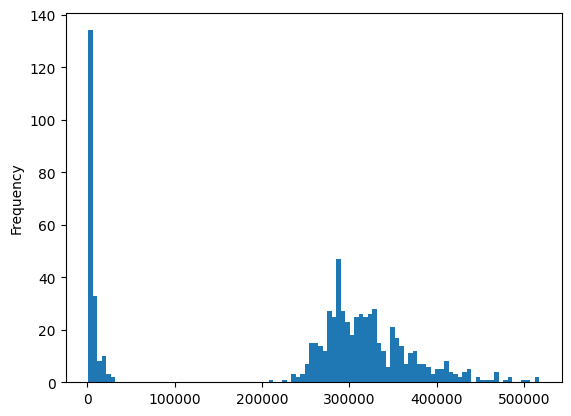

In [24]:
layers_df.score[layers_df.score > 0].plot.hist(bins=100)

In [25]:
(layers_df.score > layers_df.score.quantile(.99)).sum()

84

In [26]:
layers_df["transformer_block"] = layers_df.prc.apply(lambda x: int(x.split(".")[1]))

In [29]:
layers_df["transformer_block"][layers_df.score > layers_df.score.quantile(.8)].value_counts()

transformer_block
27    98
17    93
20    51
18    27
21    21
1     20
26    20
25    20
24    20
23    20
22    20
19    20
16    20
15    20
0     20
13    20
12    20
11    20
10    20
9     20
8     20
7     20
6     20
5     20
4     20
3     20
2     20
14    20
Name: count, dtype: int64